# Feature tracing

## Config and preprocessing

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
FEATURE_ID = 4542
# FEATURE_ID = 8
# FEATURE_ID = 10996
SAMPLE_IDX = 38
TOKEN_IDX = 73
BATCH_SIZE = 64
HEAD = 3

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from transformer_lens import utils

from sprint.loading import load_all
from sprint.linearization import analyze_linearized_feature
from sprint.attention import get_attn_head_contribs, get_attn_head_contribs_ov
from sprint.sae_tutorial import make_token_df, process_tokens
from sprint.visualization import plot_head_token_contribs, plot_head_token_contribs_for_prompt, visualize_topk

/opt/conda/envs/sprint/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
model, data, sae = load_all(half_precision=True, verbose=False)
batch = data[:BATCH_SIZE]  # convenience variable for callign make_token_df

Loaded pretrained model gelu-1l into HookedTransformer
Moving model to device:  cuda
Changing model dtype to torch.float16
{'batch_size': 4096,
 'beta1': 0.9,
 'beta2': 0.99,
 'buffer_batches': 12288,
 'buffer_mult': 384,
 'buffer_size': 1572864,
 'd_mlp': 2048,
 'dict_mult': 8,
 'enc_dtype': 'fp32',
 'l1_coeff': 0.0003,
 'lr': 0.0001,
 'model_batch_size': 512,
 'num_tokens': 2000000000,
 'seed': 52,
 'seq_len': 128}


In [4]:
result = analyze_linearized_feature(
    feature_idx=FEATURE_ID,
    sample_idx=SAMPLE_IDX,
    token_idx=TOKEN_IDX,
    model=model,
    data=data,
    encoder=sae,
    head=HEAD,
    batch_size=BATCH_SIZE,
)

# TODO: get rid of the TOKEN_IDX argument and automate it instead

## Feature interpretation
We look at:
* A table of specific tokens by feature activations
* A table of specific tokens by activation scores
* A table of generic tokens by unembedded token scores


In [5]:
# Table of top SAE activations

token_df = make_token_df(batch, model=model)
token_df["feature"] = utils.to_numpy(result["sae activations"][:, FEATURE_ID])
token_df.sort_values("feature", ascending=False).head(20).style.background_gradient("coolwarm")

,str_tokens,unique_token,context,batch,pos,label,feature
225,·is,·is/97,·recover·all·data.·It|·is|·a,1,97,1/97,1.418945
5472,ACC,ACC/96,CURRENCY_|ACC|OUNT,42,96,42/96,0.000000
5471,_,_/95,CONCURRENCY|_|ACC,42,95,42/95,0.000000
5470,Y,Y/94,_CONCURRENC|Y|_,42,94,42/94,0.000000
5469,ENC,ENC/93,PM_CONCURR|ENC|Y,42,93,42/93,0.000000
5468,R,R/92,·PPM_CONCUR|R|ENC,42,92,42/92,0.000000
5467,CUR,CUR/91,class·PPM_CON|CUR|R,42,91,42/91,0.000000
5466,CON,CON/90,↩ class·PPM_|CON|CUR,42,90,42/90,0.000000
5465,_,_/89,↩ ↩ ↩ class·PPM|_|CON,42,89,42/89,0.000000
5464,PM,PM/88,()↩ ↩ ↩ class·P|PM|_,42,88,42/88,0.000000


In [26]:
# Table of activation scores

token_df = make_token_df(batch, model=model)
token_df["feature"] = utils.to_numpy(result["activation scores"])
token_df.sort_values("feature", ascending=False).head(20).style.background_gradient("coolwarm")

,str_tokens,unique_token,context,batch,pos,label,feature
532,'t,'t/20,created)↩ ↩ ····#·Don|'t|·forget,4,20,4/20,1.217773
3906,'t,'t/66,CharField(_(u|'t|itle,30,66,30/66,0.690918
7058,·not,·not/18,·and·current_try·is|·not|·None,55,18,55/18,0.247314
5768,·not,·not/8,59-1·is|·not|·very,45,8,45/8,0.218750
4937,'t,'t/73,"·#·Actually,·above·doesn|'t|·seem",38,73,38/73,0.000822
3669,·not,·not/85,i].get()·is|·not|·None,28,85,28/85,-0.022293
2923,·not,·not/107,·fq·=·package·is|·not|·None,22,107,22/107,-0.085815
6529,·will,·will/1,<|BOS|>|·will|·get,51,1,51/1,-0.085815
6618,·will,·will/90,·Jaime·I·and·you|·will|·arrive,51,90,51/90,-0.101746
7767,·Additionally,·Additionally/87,"·upcoming·Tesla·Model·Y.|·Additionally|,",60,87,60/87,-0.112305


In [27]:
# Unembed feature

token_df = pd.DataFrame(
    dict(str_tokens=result["token strings"], feature_scores=result["token scores"].detach().cpu().numpy())
)
token_df.style.background_gradient("coolwarm")

,str_tokens,feature_scores
0,'t,3.189453
1,wont,2.765625
2,didnt,2.707031
3,doesnt,2.634766
4,dont,2.496094
5,Cannot,2.414062
6,cannot,2.326172
7,Already,2.326172
8,Not,2.296875
9,Shall,2.273438


Loaded pretrained model gelu-1l into HookedTransformer
Moving model to device:  cuda
Changing model dtype to torch.float16
Model device: cuda:0
Tokens shape: torch.Size([215402, 128]), dtype: torch.int64, device: cuda:0


) missing from current font./visualization.py:69: UserWarning: Glyph 13 (
  plt.tight_layout()
) missing from current font.ython3.10/site-packages/IPython/core/events.py:93: UserWarning: Glyph 13 (
  func(*args, **kwargs)
) missing from current font.ython3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


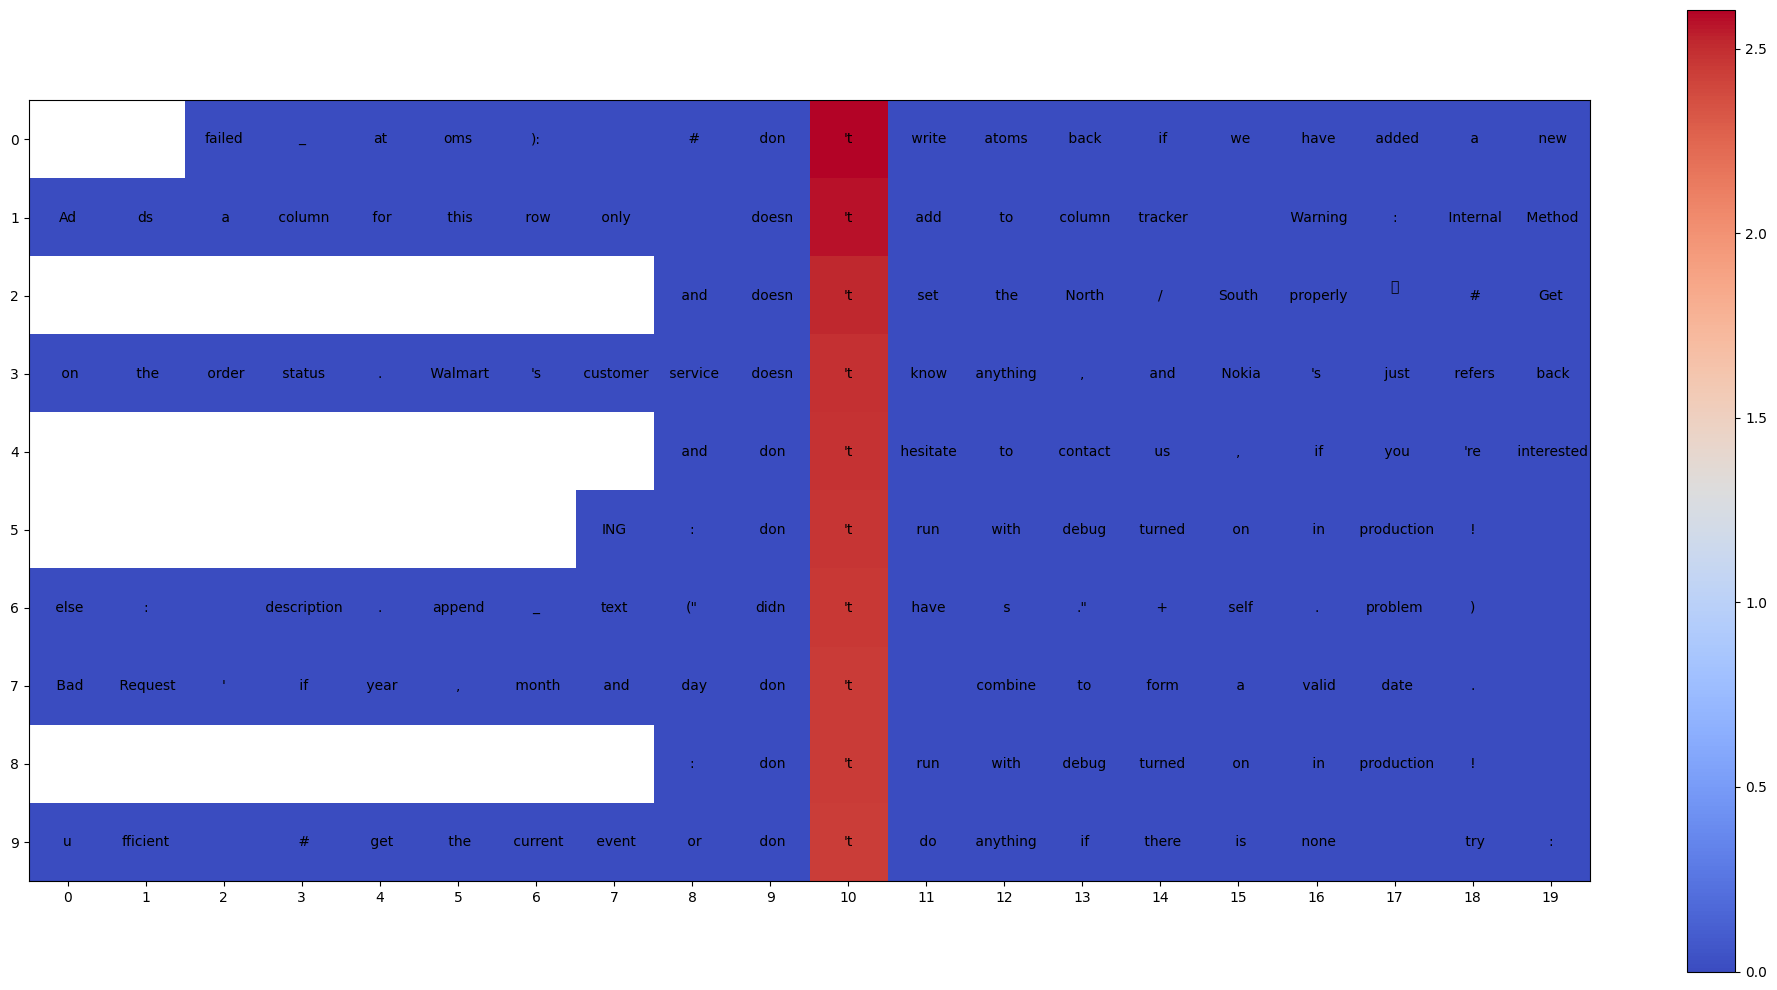

In [28]:
# A more contextualized view of the feature
# This looks at the ACTUAL top K activations in the dataset, not just in a batch

visualize_topk(feature_id=FEATURE_ID, n_examples=10, model=model, pad=True, clip=10)

I skipped the exploration of linearization points, because you can do this by just changing the `sample_idx` and `token_idx` parameters in `anlyze_linearized_feature()`

## Attention

### Head contributions

In [29]:
attn_contribs = get_attn_head_contribs(
    model=model, data=data, layer=0, range_normal=result["mid"], batch_size=BATCH_SIZE
)

OutOfMemoryError: CUDA out of memory. Tried to allocate 8.00 GiB. GPU 0 has a total capacty of 22.16 GiB of which 1.96 GiB is free. Process 3028964 has 20.19 GiB memory in use. Of the allocated memory 11.81 GiB is allocated by PyTorch, and 7.92 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

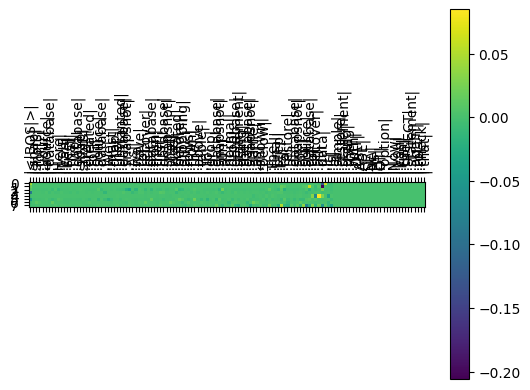

In [11]:
plot_head_token_contribs(model=model, contribs=attn_contribs, tokens=data[SAMPLE_IDX], dst=TOKEN_IDX)
plt.show()

Loaded pretrained model gelu-1l into HookedTransformer
Moving model to device:  cuda
Changing model dtype to torch.float16
Model device: cuda:0


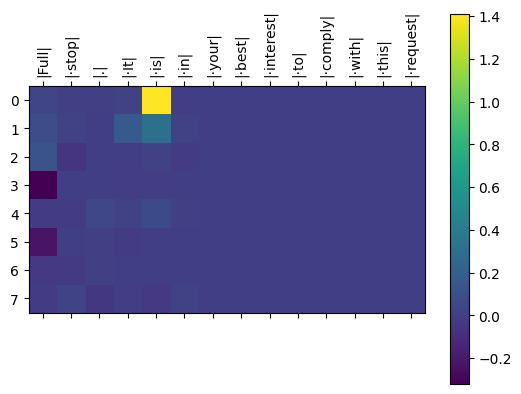

In [12]:
# prompt = "\n           'sms_id_string':   ('"
prompt = "Full stop. It is in your best interest to comply with this request"
plot_head_token_contribs_for_prompt(
    model=model,
    prompt=prompt,
    range_normal=result["mid"],
    # dst=-1,
    dst=5,
    prepend_bos=True,
)
plt.show()

# TODO: figure out whether there's an off-by-one error in the attention visualization
# TODO: fix the activating examples visualization

### OV circuit

In [17]:
# Scores when OV circuit is accounted for before unembedding

token_df = pd.DataFrame(
    dict(
        str_tokens=process_tokens(result["OV token strings"], model=model),
        feature_scores=result["OV token scores"].detach().cpu().numpy(),
    )
)
token_df.style.background_gradient("coolwarm")

,str_tokens,feature_scores
0,Equal,0.299561
1,·Draft,0.297852
2,lich,0.286621
3,·Wizard,0.275146
4,ynamic,0.273682
5,·Local,0.270752
6,Validation,0.269531
7,·Civil,0.269043
8,·Validation,0.267578
9,Figure,0.265137


In [16]:
# Same as above, but ln + OV

token_df = pd.DataFrame(
    dict(
        str_tokens=process_tokens(result["ln+OV token strings"], model=model),
        feature_scores=result["ln+OV token scores"].detach().cpu().numpy(),
    )
)
token_df.style.background_gradient("coolwarm")

# TODO: look into what's broken about this
# TODO: what's going on with the positional embeddings?

,str_tokens,feature_scores
0,�,0.266846
1,ot,0.251465
2,,0.227905
3,········,0.222290
4,·L,0.220825
5,�,0.217773
6,�,0.201904
7,,0.197876
8,an,0.192871
9,·con,0.188232


### QK circuit

In [15]:
token_df = pd.DataFrame(
    dict(
        str_tokens=process_tokens(result["QK token strings"], model=model),
        feature_scores=result["QK token scores"].detach().cpu().numpy(),
    )
)
token_df.style.background_gradient("coolwarm")

,str_tokens,feature_scores
0,··↩ ···,0.608398
1,·inform,0.597168
2,··↩ ·,0.591797
3,↩ ·,0.562500
4,·accommodate,0.558594
5,·assisting,0.555664
6,"·),",0.553223
7,Cannot,0.551270
8,·introduce,0.544922
9,↩ ·····,0.541992
